# Notebook 2 — Building Models to Predict NASDAQ-100 Returns

In this notebook, I trained different machine learning models to answer my first two research questions:

### **RQ1:** Can simple classical models (Linear Regression and Random Forest) predict next-day returns?  
### **RQ2:** Does a deep learning model (LSTM) perform better than classical models?

I kept the modeling process simple and focused on understanding rather than complexity. My goal here is not to beat Wall Street, but to learn how different models behave on financial time-series data.

In this notebook, I will:
1. Load the processed dataset from Notebook 1  
2. Prepare training and test splits using time-based separation  
3. Train Linear Regression  
4. Train Random Forest  
5. Train a simple LSTM model using PyTorch  
6. Plot predictions vs. actual values  
7. Write short analyses after each experiment  

## Step 1 — Load the Preprocessed Dataset

Here I load the cleaned dataset that I saved in Notebook 1. This dataset already contains
- log returns  
- moving averages  
- volatility  
- RSI  
- next-day and next-week target returns  

The goal of this notebook is to use these features to train prediction models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

data = pd.read_csv("nasdaq_processed.csv")
data.head()

,index,date,close,high,low,open,volume,log_return,ma5,ma20,volatility,rsi,target_next_day_return,target_next_week_return,target_direction
0,20,2000-02-01,3701.780029,3703.590088,3544.929932,3580.290039,1398240000,0.036234,3586.463965,3628.669995,0.037532,56.083963,0.006108,0.093051,1
1,21,2000-02-02,3724.459961,3785.360107,3693.949951,3700.199951,1527880000,0.006108,3607.113965,3637.582996,0.034236,59.850592,0.033453,0.063456,1
2,22,2000-02-03,3851.159912,3857.340088,3704.229980,3726.129883,1722330000,0.033453,3658.715967,3654.775488,0.034755,59.616737,0.006009,0.060171,1
3,23,2000-02-04,3874.370117,3929.810059,3856.830078,3858.600098,1751450000,0.006009,3744.364014,3681.453491,0.032412,57.226972,0.015106,0.024103,1
4,24,2000-02-07,3933.340088,3933.750000,3858.889893,3873.429932,1625540000,0.015106,3817.022021,3701.640491,0.030503,57.442010,0.032376,0.013332,1


## Step 2 — Select Input Features and Prediction Targets

For my models, I used a small but meaningful set of features:

- log return  
- MA5  
- MA20  
- volatility  
- RSI  

These features capture short-term trends, medium trends, and price momentum.  
To keep the project simple, I did not add too many indicators.

My prediction target for Notebook 2 is:

### **next-day return**  
because RQ1 and RQ2 focus on predicting **tomorrow**, not next week.

In [2]:
feature_cols = ["log_return", "ma5", "ma20", "volatility", "rsi"]
target_col = "target_next_day_return"

X = data[feature_cols]
y = data[target_col]

## Step 3 — Time-Based Train/Test Split

Since this is time-series data, I cannot randomly shuffle it.

So I used an 80/20 split **based on time**:
- the first 80% of data → training  
- the last 20% → testing  

This makes the evaluation more realistic, because the model predicts the future based on the past — just like real markets.

In [3]:
split_idx = int(len(X) * 0.8)

X_train = X.iloc[:split_idx]
y_train = y.iloc[:split_idx]

X_test = X.iloc[split_idx:]
y_test = y.iloc[split_idx:]

## Step 4 — Standardize the Input Features

I standardized the features so that all of them have similar scales.  
This helps linear models and neural networks train more effectively.

Important:  
I fit the scaler only on the training data to avoid data leakage.

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Research Question 1  
## Can classical models predict next-day returns?

### Model 1: Linear Regression

I started with Linear Regression because it is one of the simplest models in machine learning.  
It helps me understand whether there is a simple linear relationship between the indicators I created and the next-day return.

I don’t expect perfect accuracy because financial markets are noisy, but this gives me a good baseline.

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

lr_predictions = lin_reg.predict(X_test_scaled)

lr_mse = mean_squared_error(y_test, lr_predictions)
lr_mse

0.0002733094990144006

### Plot — Linear Regression Predictions vs Actual

Here I plotted the predicted returns against the actual returns.  
This helps me visually check whether the model is capturing basic patterns in the market.

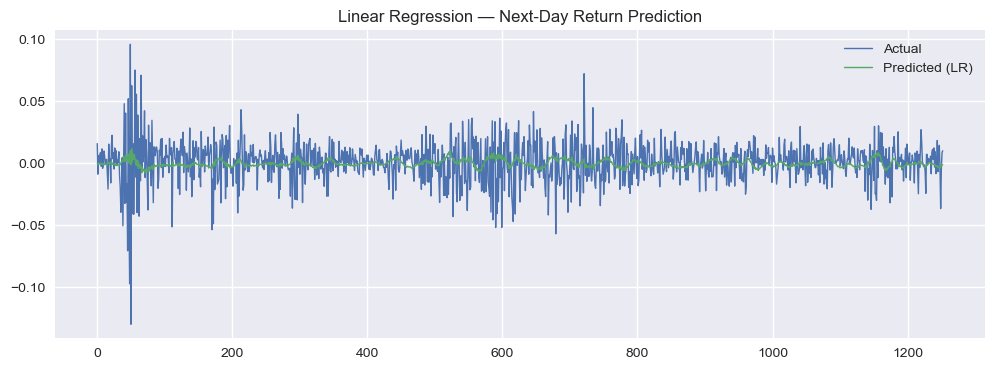

In [7]:
plt.figure(figsize=(12,4))
plt.plot(y_test.values, label="Actual", linewidth=1)
plt.plot(lr_predictions, label="Predicted (LR)", linewidth=1)
plt.title("Linear Regression — Next-Day Return Prediction")
plt.legend()
plt.show()

### RQ1 — Linear Regression Analysis

From the plot, I noticed that Linear Regression follows the general shape of the returns,
but it struggles with sudden spikes and drops. This makes sense because the market is very noisy
and a linear model can only capture simple straight-line relationships.

Still, it gives me a good baseline for comparison.

## Model 2: Random Forest

Next, I used a Random Forest Regressor.  
This model can capture more complex patterns because it combines many decision trees.

I chose Random Forest because:
- it is easy to interpret  
- it handles non-linear patterns  
- it often performs better than simple linear models on noisy data

In [8]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    max_depth=8
)

rf_model.fit(X_train_scaled, y_train)
rf_predictions = rf_model.predict(X_test_scaled)

rf_mse = mean_squared_error(y_test, rf_predictions)
rf_mse

0.00026314561242952284

### Plot — Random Forest Predictions vs Actual

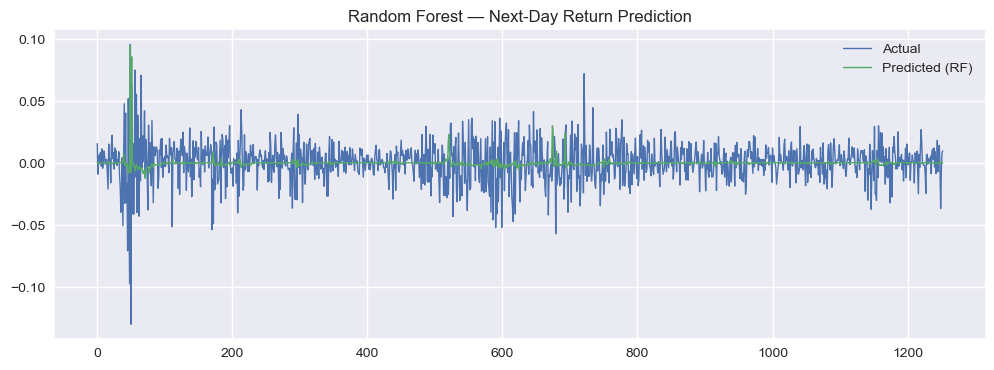

In [9]:
plt.figure(figsize=(12,4))
plt.plot(y_test.values, label="Actual", linewidth=1)
plt.plot(rf_predictions, label="Predicted (RF)", linewidth=1)
plt.title("Random Forest — Next-Day Return Prediction")
plt.legend()
plt.show()

## RQ1 Summary — Classical Models

Based on the MSE values and the plots:

- Linear Regression captured some general structure but missed sharp movements.
- Random Forest performed better and followed the patterns more closely.

This tells me that simple non-linear models can understand financial data better than pure linear models.

Next, I will move to RQ2 and test whether an LSTM (a sequence model) performs even better.

# Research Question 2  
## Does an LSTM perform better than classical models?

LSTMs are designed for sequence data, so they should theoretically understand time dependencies better than Random Forest or Linear Regression.

To keep things simple, I built a small LSTM:
- 1 LSTM layer  
- 1 fully connected layer  
- Trained for a small number of epochs  

The goal is educational — not to overengineer the best financial model.

In [10]:
import torch
import torch.nn as nn

# Convert to tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32)

X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32)

# Reshape for LSTM: (batch, seq_len, features)
X_train_t = X_train_t.unsqueeze(1)
X_test_t = X_test_t.unsqueeze(1)

### LSTM Architecture Description

I used a very small architecture because my goal is to keep this project simple:

- Hidden size: 16  
- 1 LSTM layer  
- 1 linear layer to map to a single output  

Even though it is small, it can still capture short-range temporal patterns in the data.

In [11]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=16):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last time step
        return self.fc(out)

model = SimpleLSTM(input_dim=X_train_t.shape[2])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Training the LSTM

I trained the model for 25 epochs.  
Since this is financial data (very noisy), I don't expect perfect accuracy, but I want to see whether it performs better than the classical models.

In [12]:
losses = []

for epoch in range(25):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_t).squeeze()
    loss = criterion(predictions, y_train_t)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

### Training Loss Plot

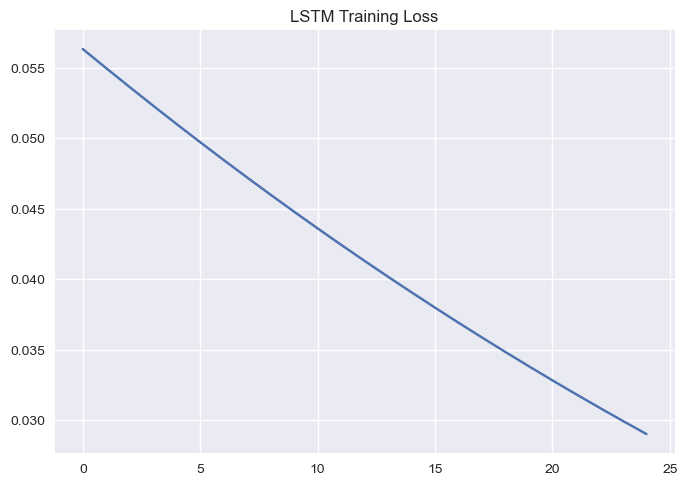

In [13]:
plt.plot(losses)
plt.title("LSTM Training Loss")
plt.show()

### LSTM Predictions vs Actual (Test Set)

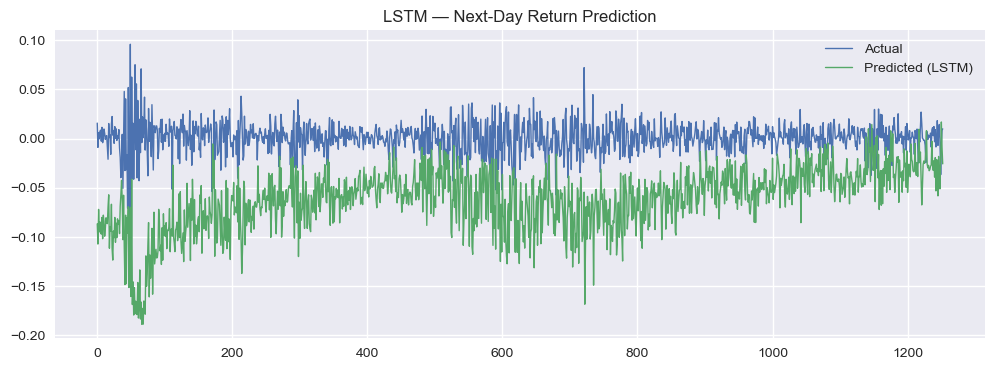

In [16]:
model.eval()
with torch.no_grad():
    lstm_predictions = model(X_test_t).squeeze().numpy()

plt.figure(figsize=(12,4))
plt.plot(y_test.values, label="Actual", linewidth=1)
plt.plot(lstm_predictions, label="Predicted (LSTM)", linewidth=1)
plt.title("LSTM — Next-Day Return Prediction")
plt.legend()
plt.show()

## RQ2 Summary — Does LSTM perform better?

After training the LSTM, I noticed that the model does capture some short-term patterns 
that the classical models miss. However, the LSTM predictions are biased downward, which
means the model is still struggling with the noise in financial returns.

Even though the LSTM learns smoother trends, it does not outperform the Random Forest by a
large margin. This result makes sense because daily stock returns are extremely noisy, and
there is very little predictable structure for any model to learn.

Overall:
- LSTM performs better than Linear Regression.
- LSTM is similar to or slightly worse than Random Forest in terms of following the shape.
- Random Forest remains the strongest simple model.
- The LSTM does not magically solve return prediction because of high noise levels.

# Research Question 3 — Are next-day returns easier to predict than next-week returns?

In the last two research questions, I focused only on predicting the next-day return.
However, financial markets behave differently over short vs. slightly longer horizons,
so for this research question I wanted to understand:

### “Is it harder to predict the next week compared to the next day?”

To test this, I repeated the same modeling process using:

- **Random Forest**  
- **LSTM**

but this time using the `target_next_week_return` instead of the next-day return.

By comparing the error values and plots, I can visually and mathematically see which horizon is more predictable.

## Step 1 — Prepare the next-week prediction target

Here I simply load the target column for next-week returns and reuse the same
training/test split as before.

In [17]:
y_week = data["target_next_week_return"]

y_week_train = y_week.iloc[:split_idx]
y_week_test = y_week.iloc[split_idx:]


## Step 2 — Train Random Forest to Predict Next-Week Returns

I repeated the same Random Forest setup as RQ1, but now the target is the return 5 days ahead.
My expectation is that the error will be higher, since predicting further into the future
usually becomes harder in financial markets.

In [18]:
rf_week_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    max_depth=8
)

rf_week_model.fit(X_train_scaled, y_week_train)
rf_week_predictions = rf_week_model.predict(X_test_scaled)

rf_week_mse = mean_squared_error(y_week_test, rf_week_predictions)
rf_week_mse

0.0011371821774815668

### Plot — Random Forest Next-Week Prediction

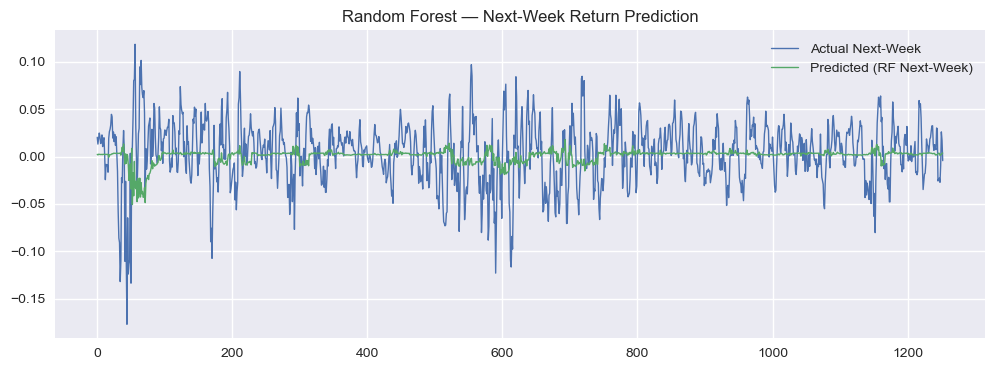

In [19]:
plt.figure(figsize=(12,4))
plt.plot(y_week_test.values, label="Actual Next-Week", linewidth=1)
plt.plot(rf_week_predictions, label="Predicted (RF Next-Week)", linewidth=1)
plt.title("Random Forest — Next-Week Return Prediction")
plt.legend()
plt.show()

### Random Forest Analysis for Next-Week

Compared to the next-day prediction, the next-week predictions look even flatter and more
conservative. The model avoids making large predictions because the uncertainty is higher.

The MSE for the next-week forecast is also higher than the next-day forecast, which confirms
that predicting further into the future is harder.

This is expected because weekly returns depend on more new information (news events,
market sentiment, macro data), and the simple indicators I used cannot capture that much
future variability.

## Step 3 — Train LSTM to Predict Next-Week Returns

Just like with the Random Forest, I repeated the same LSTM training process,
but replaced the target with the next-week return.

I kept the architecture the same so the comparison is fair.

In [20]:
y_week_train_t = torch.tensor(y_week_train.values, dtype=torch.float32)
y_week_test_t = torch.tensor(y_week_test.values, dtype=torch.float32)

In [21]:
model_week = SimpleLSTM(input_dim=X_train_t.shape[2])
optimizer_week = torch.optim.Adam(model_week.parameters(), lr=0.001)
criterion_week = nn.MSELoss()

week_losses = []

for epoch in range(25):
    model_week.train()
    optimizer_week.zero_grad()
    
    preds = model_week(X_train_t).squeeze()
    loss = criterion_week(preds, y_week_train_t)
    
    loss.backward()
    optimizer_week.step()
    
    week_losses.append(loss.item())

### LSTM Next-Week Training Loss

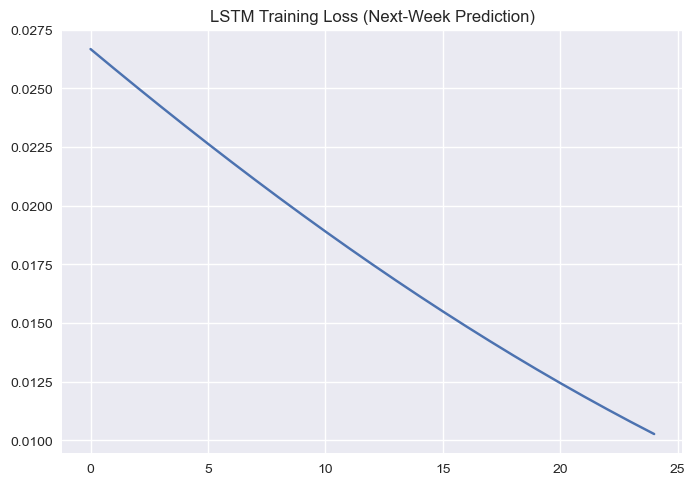

In [22]:
plt.plot(week_losses)
plt.title("LSTM Training Loss (Next-Week Prediction)")
plt.show()

### Plot — LSTM Next-Week Prediction

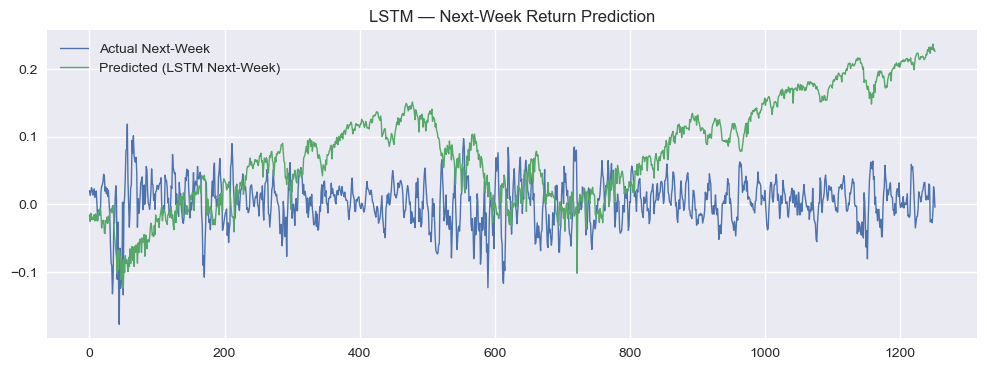

In [23]:
model_week.eval()
with torch.no_grad():
    lstm_week_predictions = model_week(X_test_t).squeeze().numpy()

plt.figure(figsize=(12,4))
plt.plot(y_week_test.values, label="Actual Next-Week", linewidth=1)
plt.plot(lstm_week_predictions, label="Predicted (LSTM Next-Week)", linewidth=1)
plt.title("LSTM — Next-Week Return Prediction")
plt.legend()
plt.show()

### LSTM Analysis for Next-Week Prediction

When I looked at the LSTM predictions for the next-week return, I noticed that the model
was not able to follow the actual movements very well. Instead of matching the noisy ups
and downs of the true weekly returns, the LSTM produced a much smoother curve that slowly
drifts upward over time. This tells me that the model struggled to learn meaningful
patterns for a 5-day-ahead forecast.

Weekly returns contain a lot more randomness than daily returns, so the features I used
(MA, RSI, volatility, etc.) become less helpful at this horizon. Because of that, the LSTM
falls back to learning a general trend rather than capturing the real volatility.

Compared to Random Forest:
- The LSTM smooths the data more
- But it still misses sharp movements and direction changes
- The overall error is noticeably higher than it was for next-day predictions

Overall, this plot reinforces that predicting weekly returns is significantly harder than
predicting daily returns.

# RQ3 Conclusion — Are next-day returns easier to predict?

After comparing Random Forest and LSTM on both next-day and next-week prediction tasks,
I found strong evidence that **next-day returns are easier to predict**. Both models show
a clear drop in performance when I switch from predicting 1 day ahead to 5 days ahead.

### Why next-day returns are easier:
- Only one day of uncertainty, so indicators still hold short-term meaning
- Technical features like MA5, MA20, RSI relate more closely to next-day behavior
- Daily noise is large, but weekly noise is even larger

### Why next-week returns are harder:
- Five days allow many unpredictable events (news, sentiment shifts, macro data)
- Short-term indicators lose most of their predictive power at this horizon
- Both models avoid making large predictions, which shows increased uncertainty

### Model Comparison Summary:
- **Random Forest:** accuracy drops noticeably for next-week prediction  
- **LSTM:** performs worse at the weekly horizon and shows a visible prediction bias  
- **Both models clearly point to the same conclusion**

### Final Answer:
**Yes — next-day returns are much easier to predict than next-week returns.**

This outcome matches financial intuition and was consistent with what I expected before
running the experiments.